# Retrieve Route Attributes from List of Edges IDs and the Direction Travelled
We have a list of edges or turns (depending on the settings) from Dijkstra, and we need to get the route attributes (how many turns, how much feet up, miles of bike facility, etc) to report the route characterstics of a trip.

In [75]:
from pathlib import Path
import time
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from shapely.ops import MultiLineString
import pandas as pd
import math
import matplotlib.pyplot as plt

import summarize_route

In [76]:
import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

In [77]:
with (config['calibration_fp']/'ready_for_calibration.pkl').open('rb') as fh:
    ready_for_calibration = pickle.load(fh)
print(len(ready_for_calibration),'trips')

#new pickles
with (config['cycleatl_fp']/'trips_4.pkl').open('rb') as fh:
    trips = pickle.load(fh)
trips = trips[trips['tripid'].isin(ready_for_calibration.keys())]

with (config['cycleatl_fp']/'users_4.pkl').open('rb') as fh:
    users = pickle.load(fh)
print(users.shape[0],'users')
users = users[users['userid'].isin(trips['userid'])]
print(users.shape[0],'users')

#recalculate the number trips
users['matched_trips'] = users['userid'].map(trips.groupby('userid').size())

1936 trips
721 users
586 users


# Barplot on trips per user

In [78]:
print((users['matched_trips'] > 10).sum(),'users had above 10 trips')

26 users had above 10 trips


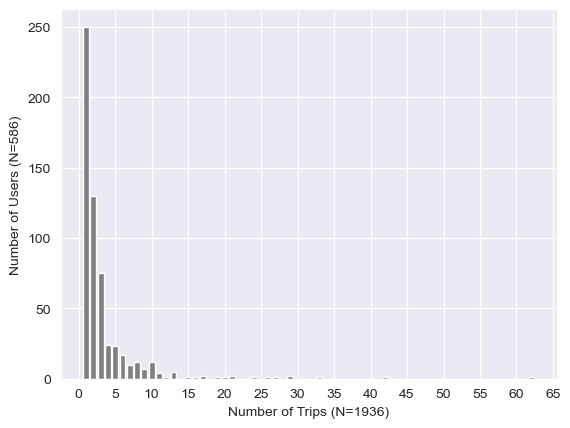

In [79]:

# Count the number of users for each number of trips matched
trip_counts = users['matched_trips'].value_counts().sort_index()

# Create bar plot
fig, ax = plt.subplots()
ax.bar(trip_counts.index, trip_counts.values, color='grey')

# Set axis labels
ax.set_xlabel(f'Number of Trips (N={trips.shape[0]})')
ax.set_ylabel(f'Number of Users (N={users.shape[0]})')

# Set x-axis ticks every 5 bins
#ax.set_xticks(range(trip_counts.index.min(), trip_counts.index.max() + 1, 5))
ax.set_xticks(range(0, trip_counts.index.max() + 5, 5))

plt.show()

# User Characterstics

In [80]:
#TODO make a more elegant solution that auto creates the table in the report
# users['gender'].value_counts()
# users['age'].value_counts()
# users['income'].value_counts()
# users['rider_type'].value_counts()

# Trip Characterstics

In [81]:
#trips['trip_type'].value_counts()

# Network Import

In [82]:
#export calibration network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links, turns_df = pickle.load(fh)

#set index for quick retrieval
links.set_index(['linkid','reverse_link'],inplace=True)
turns_df.set_index(['source_linkid','source_reverse_link','target_linkid','target_reverse_link'],inplace=True)

In [83]:
links.columns

Index(['A', 'B', 'link_type', 'osmid', 'highway', 'oneway', 'name', 'year',
       'AADT', 'truck_pct', 'speed', 'length_ft', 'lanes', 'link_type_new',
       'motorized', 'facility_fwd', 'improvement', 'ascent_ft',
       'ascent_grade_%', 'above_4', 'mixed_traffic_no_facil',
       'mixed_traffic_w_facil', 'travel_time_min', 'test_column', 'length_mi',
       'geometry'],
      dtype='object')

In [84]:
#other attributes
gdot_lanes = gpd.read_file(config['network_fp']/"conflation.gpkg",layer='gdot_lanes')


In [85]:
gdot_lanes

,osmid,route_type,gdot_lanes,geometry
0,9106184,Non-Interstate,1.0,"MULTILINESTRING ((2212222.427 1326354.289, 221..."
1,9106187,Non-Interstate,1.0,"LINESTRING (2211492.670 1326020.809, 2211522.6..."
2,9106206,Non-Interstate,1.0,"LINESTRING (2209989.752 1323728.890, 2210008.8..."
3,9106226,Non-Interstate,1.0,"MULTILINESTRING ((2214111.451 1319254.189, 221..."
4,9106247,Non-Interstate,1.0,"MULTILINESTRING ((2212466.471 1323277.490, 221..."
...,...,...,...,...
18546,1123600932,Non-Interstate,1.0,"LINESTRING (2224698.425 1364502.911, 2224676.5..."
18547,1123605049,State Route,2.0,"MULTILINESTRING ((2241145.961 1371398.028, 224..."
18548,1123605050,State Route,1.0,"MULTILINESTRING ((2241108.732 1371430.988, 224..."
18549,1124407873,Non-Interstate,2.0,"LINESTRING (2226812.870 1368235.907, 2226843.8..."


# Import Map Matched and Shortest Path Data (and impedance calibrated in the future)
This is where we want to look at the makeup of the chosen routes to know what to include in the impedance function. Because route atttributes have to be aggregated from the links, continuous variables have to be averaged or split into ordinal variables in order to represented.

In most cases, it seems 

In [86]:
links['length_mi'] = links['length_ft'] / 5280

In [87]:
cols_to_summarize = {
    'facility_fwd': "category",
    'AADT': ("threshold",[10000]), # above 10000 since this was the value used in broach
    'truck_pct': ("threshold",[5]),
    'speed': "category",
    'lanes': "category",
    'above_4': "boolean"
    #'mixed_traffic_no_facil': "boolean",
    #'mixed_traffic_w_facil': "boolean"
}

In [88]:
matched_summary = [summarize_route.route_attributes(key,item,'matched_edges',cols_to_summarize,links,turns_df) for key, item in ready_for_calibration.items()]
matched_summary = summarize_route.procees_summary_results(matched_summary,config['projected_crs_epsg'])
matched_summary.drop(columns=['tripid','geometry']).describe()

,length_mi,travel_time_min,ascent_ft,"(0,4]_prop","(4,8]_prop","(8,inf]_prop",AADT_10000_prop,facility_fwd_bike lane_prop,facility_fwd_buffered bike lane_prop,facility_fwd_cycletrack_prop,...,lanes_2_prop,lanes_3_prop,left,right,signalized,speed_0_prop,speed_1_prop,straight,truck_pct_5_prop,uturn
count,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,...,1936.0,1936.0,1936.000000,1936.000000,1936.000000,1936.0,1936.0,1936.000000,1936.000000,1936.000000
mean,3.884213,25.901383,293.833678,0.959742,0.035615,0.004267,0.227805,0.105444,0.010687,0.011720,...,0.0,0.0,1.358161,1.448864,2.605837,0.0,0.0,28.099277,0.000811,0.008006
std,2.026984,13.516684,172.367594,0.033458,0.031829,0.008833,0.255771,0.134438,0.048343,0.033492,...,0.0,0.0,0.761160,0.777373,1.737812,0.0,0.0,12.142527,0.007247,0.055153
min,0.577992,3.854267,17.000000,0.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,2.232958,14.890198,161.000000,0.940000,0.010000,0.000000,0.020000,0.000000,0.000000,0.000000,...,0.0,0.0,0.800000,0.900000,1.400000,0.0,0.0,19.300000,0.000000,0.000000
50%,3.480148,23.206926,261.000000,0.970000,0.030000,0.000000,0.130000,0.060000,0.000000,0.000000,...,0.0,0.0,1.300000,1.400000,2.200000,0.0,0.0,27.700000,0.000000,0.000000
75%,5.134436,34.238339,387.000000,0.980000,0.050000,0.010000,0.370000,0.160000,0.000000,0.000000,...,0.0,0.0,1.800000,1.900000,3.500000,0.0,0.0,36.425000,0.000000,0.000000
max,10.628288,70.873397,1350.000000,1.000000,0.220000,0.120000,1.000000,0.860000,0.800000,0.370000,...,0.0,0.0,5.100000,6.800000,9.900000,0.0,0.0,75.100000,0.130000,0.900000


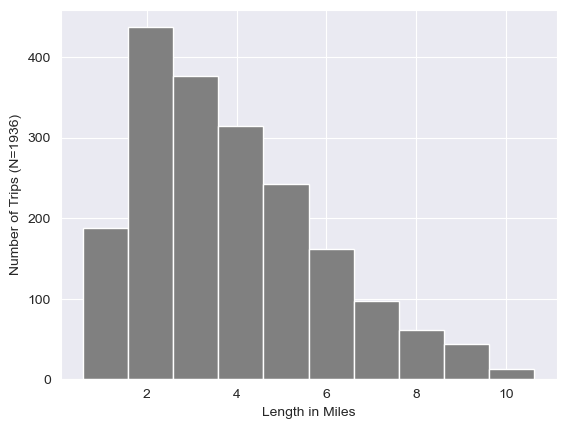

In [89]:
fig, ax = plt. subplots()
ax.hist(matched_summary['length_mi'],color='grey')

# Set axis labels
ax.set_xlabel(f'Length in Miles')
ax.set_ylabel(f'Number of Trips (N={trips.shape[0]})')

# Set x-axis ticks every 5 bins
#ax.set_xticks(range(trip_counts.index.min(), trip_counts.index.max() + 1, 5))
#ax.set_xticks(range(0, int(matched_summary['length_mi'].max()) + 5, 1))

plt.show()


In [90]:
shortest_summary = [summarize_route.route_attributes(key,item,'shortest_edges',cols_to_summarize,links,turns_df) for key, item in ready_for_calibration.items()]
shortest_summary = summarize_route.procees_summary_results(shortest_summary,config['projected_crs_epsg'])
shortest_summary.drop(columns=['tripid','geometry']).describe()

,length_mi,travel_time_min,ascent_ft,"(0,4]_prop","(4,8]_prop","(8,inf]_prop",AADT_10000_prop,facility_fwd_bike lane_prop,facility_fwd_buffered bike lane_prop,facility_fwd_cycletrack_prop,...,lanes_2_prop,lanes_3_prop,left,right,signalized,speed_0_prop,speed_1_prop,straight,truck_pct_5_prop,uturn
count,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,...,1936.0,1936.0,1936.000000,1936.000000,1936.000000,1936.0,1936.0,1936.000000,1936.000000,1936.000000
mean,3.092897,20.624591,234.900826,0.952510,0.042076,0.005196,0.329928,0.083786,0.013001,0.010114,...,0.0,0.0,1.425981,1.473760,3.108781,0.0,0.0,32.871023,0.001240,0.002221
std,1.634428,10.898980,140.795732,0.039893,0.037770,0.009907,0.270975,0.128081,0.049523,0.042340,...,0.0,0.0,0.828910,0.833791,1.745416,0.0,0.0,11.074132,0.013621,0.029644
min,0.330734,2.205457,11.000000,0.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,1.810800,12.075091,132.000000,0.930000,0.020000,0.000000,0.080000,0.000000,0.000000,0.000000,...,0.0,0.0,0.900000,0.900000,1.975000,0.0,0.0,25.900000,0.000000,0.000000
50%,2.752826,18.356873,203.000000,0.960000,0.030000,0.000000,0.290000,0.020000,0.000000,0.000000,...,0.0,0.0,1.300000,1.400000,2.800000,0.0,0.0,33.100000,0.000000,0.000000
75%,4.018002,26.793540,305.500000,0.980000,0.060000,0.010000,0.530000,0.120000,0.000000,0.000000,...,0.0,0.0,1.900000,1.900000,4.000000,0.0,0.0,40.600000,0.000000,0.000000
max,8.947385,59.664508,880.000000,1.000000,0.280000,0.070000,1.000000,0.880000,0.900000,0.540000,...,0.0,0.0,6.000000,5.900000,10.700000,0.0,0.0,63.700000,0.470000,0.600000


### Export

In [91]:
matched_summary.to_file(config['calibration_fp']/"route_attributes.gpkg",layer="matched")
shortest_summary.to_file(config['calibration_fp']/"route_attributes.gpkg",layer="shortest")

# Visualize Chosen Attributes

In [92]:
# for making graphs
renaming_dict = {
    '(0,2]_prop': "0-2% grade", 
    '(2,4]_prop': "2-4% grade", 
    '(4,6]_prop': "4-6% grade", 
    '(6,inf)_prop': "> 6% grade", 
    '(4,inf)_prop': "> 4% grade",
    'ascent_ft': "Ascent (ft)",
    'descent_ft': "Descent (ft)", 
    'beltline_prop': "On BeltLine", 
    'facility_fwd_bike lane_prop': "Bike Lane",
    'facility_fwd_buffered bike lane_prop': "Buffered Bike Lane", 
    'facility_fwd_cycletrack_prop': "Cycletrack",
    'facility_fwd_multi use path_prop': "Multi-Use Path", 
    'facility_fwd_sharrow_prop': "Sharrow or Bike Route", 
    'left': "Left Turn (per mi)",
    'length_mi': "Length (mi)", 
    'right': "Right Turn (per mi)", 
    'straight': "Straight", 
    'uturn': " U-Turn (per mi)", 
    'vehicle_traffic_prop': "Vehicle Traffic Allowed",
    'lts_0_prop': "LTS Not Rated",
    'lts_1_prop': "LTS 1",
    'lts_2_prop': "LTS 2",
    'lts_3_prop': "LTS 3",
    'lts_4_prop': "LTS 4",
}

In [93]:
x_axes_limits = {
    # '(0,2]_prop': "0-2% grade", 
    # '(2,4]_prop': "2-4% grade", 
    # '(4,6]_prop': "4-6% grade", 
    # '(6,inf)_prop': "> 6% grade", 
    '(4,inf)_prop': (-0.2,0.2),
    'ascent_ft': (-1000,1000),
    #'descent_ft': "Descent (ft)", 
    'beltline_prop': (-0.6,0.6), 
    'facility_fwd_bike lane_prop': (-0.4,0.4),
    'facility_fwd_buffered bike lane_prop': (-0.1,0.1), 
    'facility_fwd_cycletrack_prop': (-0.5,0.5),
    'facility_fwd_multi use path_prop': (-0.6,0.6), 
    'facility_fwd_sharrow_prop': (-0.3,0.3), 
    #'left': "Left Turn",
    'length_mi': (0,6), 
    #'right': "Right Turn", 
    #'straight': "Straight", 
    #'uturn': " U-Turn", 
    'vehicle_traffic_true_prop': (-0.75,0.75),
    #'lts': "LTS"
}

In [94]:
links.columns

Index(['A', 'B', 'link_type', 'osmid', 'highway', 'oneway', 'name', 'year',
       'AADT', 'truck_pct', 'speed', 'length_ft', 'lanes', 'link_type_new',
       'motorized', 'facility_fwd', 'improvement', 'ascent_ft',
       'ascent_grade_%', 'above_4', 'mixed_traffic_no_facil',
       'mixed_traffic_w_facil', 'travel_time_min', 'test_column', 'length_mi',
       'geometry'],
      dtype='object')

In [95]:
summarize_route.

SyntaxError: invalid syntax (124536299.py, line 1)

In [ ]:
#select which differences to plot and what order to plot
# cols_to_plot = ['length_mi', 'ascent_ft',
#        '(4,inf)_prop', 'vehicle_traffic_prop', 'beltline_prop', 
#        'facility_fwd_sharrow_prop','facility_fwd_bike lane_prop',
#        'facility_fwd_buffered bike lane_prop',
#        'facility_fwd_cycletrack_prop', 'facility_fwd_multi use path_prop',
#        'lts_1_prop','lts_2_prop','lts_3_prop','lts_4_prop',
#        'uturn', 'straight', 'right', 'left','signalized'
# ]

cols_to_plot = ['facility_fwd_bike lane_prop','lanes','speed','above_4']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Define the variables to plot
variables = cols_to_plot

# Number of variables
num_vars = len(variables)

# Determine grid size (e.g., 2x2)
ncols = 3
nrows = (num_vars // ncols) + (num_vars % ncols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18), constrained_layout=True)

# Set the background color of the figure
sns.set_style("darkgrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each KDE plot on a separate subplot
for ax, variable in zip(axes, variables):
    sns.kdeplot(data=matched_summary, x=variable, fill=True, ax=ax, cut=0, bw_adjust=0.5)
    #ax.set_title(renaming_dict.get(variable,variable))
    ax.set_xlabel(renaming_dict.get(variable,variable))

    # # Get the min and max values of the variable
    # min_val = matched_summary[variable].min()
    # max_val = matched_summary[variable].max()
    
    # # Calculate symmetric limits around zero
    # max_abs_val = max(abs(min_val), abs(max_val))
    # x_lim = (-max_abs_val, max_abs_val)

    # # #set varaible specific limits
    # # if x_axes_limits.get(variable,False) != False:
    # #     x_lim = x_axes_limits.get(variable,x_lim)
    
    # ax.set_xlim(x_lim)
    ax.axvline(0, color='k', linestyle='--', alpha = 0.5)  # Optional: add a vertical line at zero for reference

    # Set the background color of the axes
    #ax.set_facecolor('grey')
    #ax.grid(True, color='white')

# Remove any empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

# Show the plot
plt.show()


# Visualize Path Attribute Differences (Chosen - Shortest)
Re-create the plots that were in Dillon's paper.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
differences = matched_summary.iloc[:,2:] - shortest_summary.iloc[:,2:]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Define the variables to plot
variables = cols_to_plot

# Number of variables
num_vars = len(variables)

# Determine grid size (e.g., 2x2)
ncols = 3
nrows = (num_vars // ncols) + (num_vars % ncols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18), constrained_layout=True)

# Set the background color of the figure
sns.set_style("darkgrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each KDE plot on a separate subplot
for ax, variable in zip(axes, variables):
    sns.kdeplot(data=differences, x=variable, fill=True, ax=ax, cut=0, bw_adjust=0.5)
    #ax.set_title(renaming_dict.get(variable,variable))
    ax.set_xlabel(renaming_dict.get(variable,variable))

    # Get the min and max values of the variable
    min_val = differences[variable].min()
    max_val = differences[variable].max()
    
    # Calculate symmetric limits around zero
    max_abs_val = max(abs(min_val), abs(max_val))
    x_lim = (-max_abs_val, max_abs_val)

    #set varaible specific limits
    if x_axes_limits.get(variable,False) != False:
        x_lim = x_axes_limits.get(variable,x_lim)
    
    ax.set_xlim(x_lim)
    ax.axvline(0, color='k', linestyle='--', alpha = 0.5)  # Optional: add a vertical line at zero for reference

    # Set the background color of the axes
    #ax.set_facecolor('grey')
    #ax.grid(True, color='white')

# Remove any empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

# Show the plot
plt.show()


In [ ]:
differences.rename(columns=renaming_dict).describe().round(2)

# Cross Tabs

In [ ]:
with (cycleatl_fp/'trips_3.pkl').open('rb') as fh:
    trips = pickle.load(fh)
with (cycleatl_fp/'users_0.pkl').open('rb') as fh:
    users = pickle.load(fh)

In [ ]:
trips.columns

In [ ]:
users.columns

In [ ]:
#pretend they're not the same person for now and then later fix the cycleatl data processing code

In [ ]:
differences['tripid'] = matched_summary['tripid']

In [ ]:
differences_w_info = differences.merge(pd.merge(trips,users,on='userid'),on='tripid')

In [ ]:
differences_w_info['rider_type'].value_counts()

In [ ]:
trips.columns

In [ ]:
users.columns

In [ ]:
hue = "rider_type"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Define the variables to plot
variables = cols_to_plot

# Number of variables
num_vars = len(variables)

# Determine grid size (e.g., 2x2)
ncols = 3
nrows = (num_vars // ncols) + (num_vars % ncols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20), constrained_layout=True)

# Set the background color of the figure
sns.set_style("darkgrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each KDE plot on a separate subplot
i = 0
for ax, variable in zip(axes, variables):
    if i == 0:
        sns.kdeplot(data=differences_w_info, x=variable, fill=False, ax=ax, cut=0, bw_adjust=0.5, hue=hue)
        i += 1
    else:
        sns.kdeplot(data=differences_w_info, x=variable, fill=False, ax=ax, cut=0, bw_adjust=0.5, hue=hue, legend = False)
    #ax.set_title(renaming_dict.get(variable,variable))
    ax.set_xlabel(renaming_dict.get(variable,variable))

    # Get the min and max values of the variable
    min_val = differences_w_info[variable].min()
    max_val = differences_w_info[variable].max()
    
    # Calculate symmetric limits around zero
    max_abs_val = max(abs(min_val), abs(max_val))
    x_lim = (-max_abs_val, max_abs_val)

    #set varaible specific limits
    if x_axes_limits.get(variable,False) != False:
        x_lim = x_axes_limits.get(variable,x_lim)
    
    ax.set_xlim(x_lim)
    ax.axvline(0, color='k', linestyle='--', alpha = 0.5)  # Optional: add a vertical line at zero for reference

# Remove any empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

# Show the plot
plt.show()


In [ ]:
#multiple_entries = users['userid'].apply(lambda x: isinstance(x,list))

#users['rider_type'].apply()
# def list_to_single(row):
#     if isinstance(row['userid'],list) == False:
#         return row
    
#     #remove nulls
#     if isinstance(row['rider_type'],list):


#     row["rider_type"]


In [ ]:
#have a bad elevation link
edges_w_attr.loc[edges_w_attr['ascent_ft'].sort_values(ascending=False).head(10).index,['name','ascent_ft','descent_ft','geometry']].explore()

In [ ]:
matched_summary.loc[[matched_summary['ascent_ft'].idxmax()]].explore()

In [ ]:
differences.sort_values('ascent_ft',ascending=False).head(10)

In [ ]:
sns.kdeplot(data=matched_summary[link_type_new],cut=0,bw_adjust=5)

# Deprecated past here

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = summary_df.copy()

# Assuming your dataframe is named df
# Drop any rows with missing values (if any)
df.fillna(0,inplace=True)

# Define features and target variable
X = df.drop(columns=['tripid', 'geometry', 'length_ft'])
y = df['length_ft']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
regressor = DecisionTreeRegressor(random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()


In [ ]:
feature_importances = pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)


In [ ]:
import random
testtrip = random.choice(list(matched_traces_dict.keys()))
testtrip = matched_traces_dict[testtrip]

In [ ]:
summary_dict = {}

#get edges
route = testtrip['edges']


In [ ]:
#get route and turns
route = [tuple(x) for x in testtrip['edges'].values]
turns = [(route[i][0],route[i][1],route[i+1][0],route[i+1][1]) for i in range(0,len(route)-1)]

In [ ]:
'''
Two different types of summarization:

Instance based (turns, signals, bridges, etc)

Length based on certain tag (bike facilities)

Cumulative (length,elevation)

'''

summary_attributes = {}

#get trip date for the bike facility check
trip_date_year = testtrip['trace'].iloc[0,2].year

#get route and turns
route = testtrip['edges']
turns = [(route.values[i][0],route.values[i][1],route.values[i+1][0],route.values[i+1][1]) for i in range(0,len(route.values)-1)]
turns = pd.DataFrame(turns,columns=['source_linkid','source_reverse_link','target_linkid','target_reverse_link'])


In [ ]:

#retrieve attributes
route_w_attr = pd.merge(route,edges_w_attr,on='linkid')
turns_w_attr = pd.merge(turns,turns_df,on=['source_linkid','source_reverse_link','target_linkid','target_reverse_link'])

#turn to gdf
route_w_attr = gpd.GeoDataFrame(route_w_attr,geometry='geometry',crs=config['projected_crs_epsg'])
summary_attributes["geometry"] = MultiLineString(route_w_attr['geometry'].tolist())

#flip relevant attributes
route_w_attr.loc[route_w_attr['reverse_link']==True,ascent_columns+descent_columns+bike_facils] = \
    route_w_attr.loc[route_w_attr['reverse_link']==True,descent_columns+ascent_columns+bike_facils[::-1]].values

#set the bike facility to na if the trip date was before the bike facility
route_w_attr.loc[route_w_attr['year'] > trip_date_year,bike_facils] = np.nan

#summary columns
summary_attributes["length_ft"] = route_w_attr['length_ft'].sum().round(0)
summary_attributes["ascent_m"] = route_w_attr['ascent_m'].sum().round(0)
summary_attributes["descent_m"] = route_w_attr['descent_m'].sum().round(0)

# average grade by category (from broach)
zero_to_two = (route_w_attr['ascent_grade_%'] > 0) & (route_w_attr['ascent_grade_%'] <= 2)
two_to_four = (route_w_attr['ascent_grade_%'] > 2) & (route_w_attr['ascent_grade_%'] <= 4)
four_to_six = (route_w_attr['ascent_grade_%'] > 4) & (route_w_attr['ascent_grade_%'] <= 6)
six_and_beyond = (route_w_attr['ascent_grade_%'] > 6)
summary_attributes["zero_to_two_%_ft"] = route_w_attr.loc[zero_to_two,'length_ft'].sum().round(0)
summary_attributes["two_to_four_%_ft"] = route_w_attr.loc[two_to_four,'length_ft'].sum().round(0)
summary_attributes["four_to_six_%_ft"] = route_w_attr.loc[four_to_six,'length_ft'].sum().round(0)
summary_attributes["six_and_beyond_%_ft"] = route_w_attr.loc[six_and_beyond,'length_ft'].sum().round(0)

#TODO add this back in the elevation step and use the same limits?
#add meters on grade segments (i.e. add all in length along x to x)
#could possibly be a more accurate represntation of steep roads

# #instance columns to summarize
# count_cols = ['bridge','tunnel']
# for count_col in count_cols:
#     summary_attributes[count_col] = (route_w_attr[count_col]==True).sum().round(0)

# length of route columns to summarize
cols = ['link_type_new','facility_fwd']#['link_type','highway']#,'speedlimit_range_mph','lanes_per_direction']
for col in cols:
    #make a summary column for every unique value in that column
    for unique_val in route_w_attr[col].unique():
        #skip if nan
        if isinstance(unique_val,str) == False:
            continue
        summary_attributes[col+'.'+unique_val+'_ft'] = route_w_attr.loc[route_w_attr[col]==unique_val,'length_ft'].sum().round(0)
        
# turns
summary_attributes.update(turns_w_attr['turn_type'].value_counts().to_dict())


In [ ]:
summary_attributes

In [ ]:
df_edges['tup'] = list(zip(df_edges['linkid'],df_edges['reverse_link']))
chosen_links = df_edges.set_index('tup').loc[list_of_edges]
list_of_turns = [(list_of_edges[i][0],list_of_edges[i][1],list_of_edges[i+1][0],list_of_edges[i+1][1]) for i in range(0,len(list_of_edges)-1)]
chosen_turns = pseudo_df.set_index(['source_linkid','source_reverse_link','target_linkid','target_reverse_link']).loc[list_of_turns]
chosen_links.columns


In [ ]:
#intialize summary dict
summary_attributes = {}


In [ ]:

#trip distance
summary_attributes['trip_distance_ft'] = chosen_links['length_ft'].sum()


In [ ]:

#instance columns to summarize
count_cols = ['bridge','tunnel']
for count_col in count_cols:
    summary_attributes[count_col] = (chosen_links[count_col]==True).sum()

#general elevation
total_ascent = (chosen_links['ascent_m'].sum() / 3.28).round(0)
summary_attributes['ascent_ft'] = total_ascent 
summary_attributes['avg_ascent_grade'] = (total_ascent / chosen_links['length_ft'].sum() * 100).round(1)

#elevation broken by segment
elev_cols = ['(0,2]_ascent','(2,4]_ascent', '(4,6]_ascent', '(6,10]_ascent', '(10,15]_ascent','(15,inf]_ascent']
for elev_col in elev_cols:
    total_length = (chosen_links[elev_col].sum() / 3.28).round(0)
    summary_attributes[elev_col+'_ft'] = total_length

#pct of route columns to summarize
cols = ['link_type','highway','bike_facility_type','speedlimit_range_mph','lanes_per_direction']
for col in cols:
    #make a summary column for every unique value in that column
    for unique_val in chosen_links[col].unique():
        if (unique_val != None) | (unique_val == np.nan):
            total_length = chosen_links[chosen_links[col] == unique_val]['length_ft'].sum()
        else:
            continue
        if isinstance(unique_val,str) == False:
            unique_val = str(unique_val)
        summary_attributes[col+'.'+unique_val] = np.round(total_length/chosen_links['length_ft'].sum(),2)

# signalized and turns
summary_attributes['signalized'] = (chosen_turns['signalized']==True).sum()
summary_attributes['unsignalized'] = (chosen_turns['unsignalized']==True).sum()
turn_dict = chosen_turns['turn_type'].value_counts().to_dict()
summary_attributes.update(turn_dict)

summary_dict[tripid] = summary_attributes



In [ ]:
summary_attributes

In [ ]:
#turn into geodataframe
trips_df_info = pd.DataFrame.from_dict(summary_dict,orient='index')
trips_df_info.fillna(0,inplace=True)

In [ ]:
trips_df_info

In [ ]:
trips_df = trips_df.merge(trips_df_info,left_on='tripid',right_index=True)

In [ ]:
#TODO find the visualiztion code that we had already made

In [ ]:
# list_of_edges = list(zip(edges['linkid'],edges['reverse_link']))
# list_of_turns = [(list_of_edges[i][0],list_of_edges[i][1],list_of_edges[i+1][0],list_of_edges[i+1][1]) for i in range(0,len(list_of_edges)-1)]

# chosen_links = df_edges.set_index(['linkid','reverse_link'],drop=False).loc[list_of_edges]

# chosen_links['bridge'].value_counts()

In [ ]:
#add user info
trip_and_user = pd.read_pickle(fp/'gps_traces/trip_and_user.pkl')

trips_df = trips_df_info.merge(trip_and_user,left_index=True,right_on='tripid')

In [ ]:
trips_df.to_csv(fp/'all_attrs.csv',index=False)

In [ ]:
#instead of visualizing here visualize elsewhere?

In [ ]:

#import stochastic_optimization


In [ ]:
# fp = Path.home() / 'Documents/BikewaySimData/Projects/gdot'
# #fp = Path.home() / 'Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/BikewaySim/Data'

# with (fp / 'impedance_calibration.pkl').open('rb') as fh:
#     (df_edges,pseudo_df,pseudo_G) = pickle.load(fh)

In [ ]:
# Retrieve link/turn costs
# default below is link distance
# link_costs = dict(zip(list(zip(df_edges['source'],df_edges['target'],df_edges['linkid'])),df_edges['length_ft']))
# tup = list(zip(pseudo_df['source_A'],pseudo_df['source_B'],pseudo_df['source_linkid']))
# pseudo_df['source_cost'] = list(map(link_costs.get,tup))
# tup = list(zip(pseudo_df['target_A'],pseudo_df['target_B'],pseudo_df['target_linkid']))

# pseudo_df['target_cost'] = list(map(link_costs.get,tup))
# pseudo_df['total_cost'] = pseudo_df['source_cost'] + pseudo_df['target_cost'] #+turn_cost

# costs = pseudo_df.groupby(['source','target'])['total_cost'].min()
# nx.set_edge_attributes(pseudo_G,values=costs,name='weight')
# source = list(pseudo_G.nodes())[0]
# target = list(pseudo_G.nodes())[420]
# print(source,target)
# import networkx as nx
# length, edge_list = nx.single_source_dijkstra(pseudo_G,source,target,weight="weight")
# turn_list = [[edge_list[i][0],edge_list[i][1],edge_list[i+1][0],edge_list[i+1][1]] for i in range(len(edge_list)-1)]

# turn_cols = ['turn_type','signalized_left_straight','unsignalized_left_straight_nonlocal']
# linkid_cols = ['source_linkid','source_reverse_link','target_linkid','target_reverse_link']
# chosen_turns = pseudo_df.set_index(['source_A','source_B','target_A','target_B'],drop=False).loc[turn_list,linkid_cols+turn_cols]

# tripid = 302

# #make a single row dataframe to attach to trips_df
# stats_dict = {}
# stats_dict[tripid] = {
#     'tripid':tripid,
#     'signalized_left_straight': chosen_turns['signalized_left_straight'].sum(),
#     'unsignalized_left_straight_nonlocal': chosen_turns['unsignalized_left_straight_nonlocal'].sum()
# }
# turn_dict = chosen_turns['turn_type'].value_counts().to_dict()
# stats_dict[tripid].update(turn_dict)

# Case 1: Need to run shortest paths to create link sequence

In [ ]:
# source_links = chosen_turns[['source_linkid','source_reverse_link']]
# target_links = chosen_turns[['target_linkid','target_reverse_link']]
# source_links.columns = ['linkid','reverse_link']
# target_links.columns = ['linkid','reverse_link']
# linkids = pd.concat([source_links,target_links],ignore_index=True).drop_duplicates()
# chosen_links = df_edges.merge(linkids,on=['linkid','reverse_link'])

In [ ]:
#TODO recalculate bearing
#create pseudo graph for modeling turns
df_edges, pseudo_links, pseudo_G = modeling_turns.create_pseudo_dual_graph(links,'A','B','linkid','oneway')


In [ ]:
source = list(pseudo_G.nodes())[0]
target = list(pseudo_G.nodes())[420]

In [ ]:
source = (68209677, 68209675)
target = (69200243, 69465418)

import networkx as nx
length, path = nx.single_source_dijkstra(pseudo_G,source,target)

In [ ]:
edge_list = [(linkids[i],linkids[i+1]) for i in range(len(linkids)-1)]
edge_list

In [ ]:
edge_list = [(*path[i],*path[i+1]) for i in range(len(path)-1)]
edge_list

In [ ]:
pseudo_links.columns

In [ ]:
pseudo_links.set_index(['source_A','source_B','target_A','target_B']).loc[edge_list,'turn_type'].value_counts()